In [ ]:
!pip install Sastrawi

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# ===============================
# LIBRARY UNTUK PREPROCESSING & VISUALISASI
# ===============================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download resource NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer

# ===============================
# LIBRARY UNTUK MODELING
# ===============================
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Teknik resampling (over/under sampling)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Pipeline
from sklearn.pipeline import Pipeline

# ===============================
# LIBRARY UNTUK EVALUASI
# ===============================
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# ===============================
# LIBRARY UNTUK CROSS VALIDATION & TUNING
# ===============================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset
df = pd.read_csv('/content/Dataset Label.csv')
df.head()

full_text   status
0  Jika sobat BKD menemukan keluhan seputar layan...  Positif
1  Pemko Palangka Raya melalui Diskominfo menyele...   Netral
2  Salah satu upaya keterbukaan informasi dlm pel...  Positif
3  Halo sobat parekraf Saat kamu bingung mau mela...  Positif
4  Hai TemanKom! Berikut Data Jumlah Pengaduan Ma...   Netral

# Exploratory Data Analysis (EDA) terdiri dari
1. Jumlah Sentimen positif, netral, negatif
2. Mencari teks terpanjang dan terpendek
3. Word Cloud per kategori (Positif, Netral, Negatif)
4. Distribusi Panjang Teks
5. Hastag dan mention terbanyak

In [ ]:
# Cek jumlah baris dan kolom
print(f"Total baris: {df.shape[0]}, Total kolom: {df.shape[1]}")

Total baris: 1598, Total kolom: 2


Jumlah Status:
 status
Netral     854
Positif    407
Negatif    337
Name: count, dtype: int64


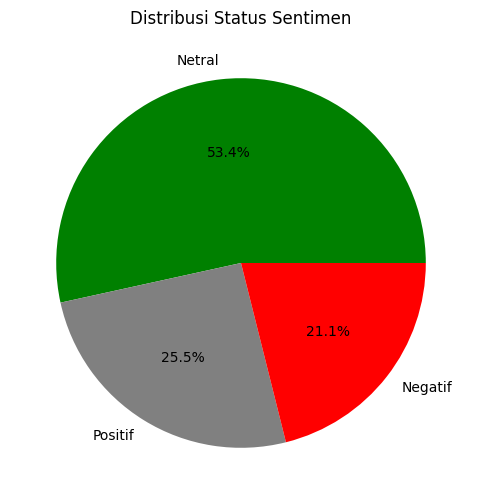

In [ ]:
# Hitung jumlah status
status_counts = df["status"].value_counts()

# Tampilkan jumlah status
print("Jumlah Status:\n", status_counts)

# Visualisasi Pie Chart
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct="%1.1f%%", colors=["green", "gray", "red"])
plt.title("Distribusi Status Sentimen")
plt.show()


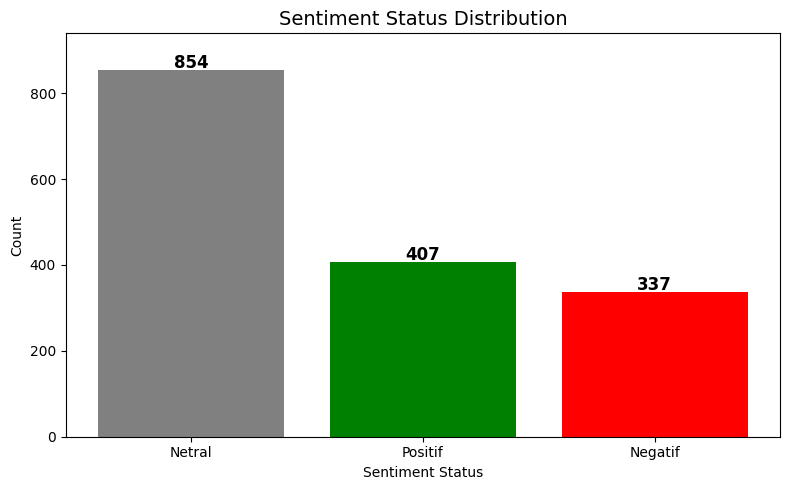

In [ ]:
# Hitung jumlah status
status_counts = df["status"].value_counts()

# Visualisasi Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(status_counts.index, status_counts.values, color=["gray", "green", "red"])

# Tambahkan jumlah di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.title("Sentiment Status Distribution", fontsize=14)
plt.xlabel("Sentiment Status")
plt.ylabel("Count")
plt.ylim(0, max(status_counts.values) * 1.1)  # agar ada ruang di atas bar untuk label angka
plt.tight_layout()
plt.show()


In [ ]:
# Menentukan teks terpanjang dan terpendek berdasarkan jumlah karakter
df["text_length"] = df["full_text"].apply(len)
longest_text = df.loc[df["text_length"].idxmax(), "full_text"]
shortest_text = df.loc[df["text_length"].idxmin(), "full_text"]

print("\nTeks Terpanjang:\n", longest_text)
print("\nTeks Terpendek:\n", shortest_text)


Teks Terpanjang:
 Panggilan jiwa sebagai anak bangsa yang ikut merasakan, menikmati dan mengisi kemerdekaan NKRI "Bahwa Kemerdekaan itu adalah hak segala bangsa, maka saya patut apresiasi SP4 LAPOR! sebagai media komunikasi cepat terpercaya, dengan pihak pemerintahan pusat, bila ada melanggar HAM yang kita temukan di lapangan, meski agak lambat tapi saya tetap optimis dan percaya menanti respon yang dapat memperbaiki, menindak lanjuti permasalahan di daerah karena banyaknya variabel masalah di daerah terjadi.

Teks Terpendek:
 #SP4NLAPOR


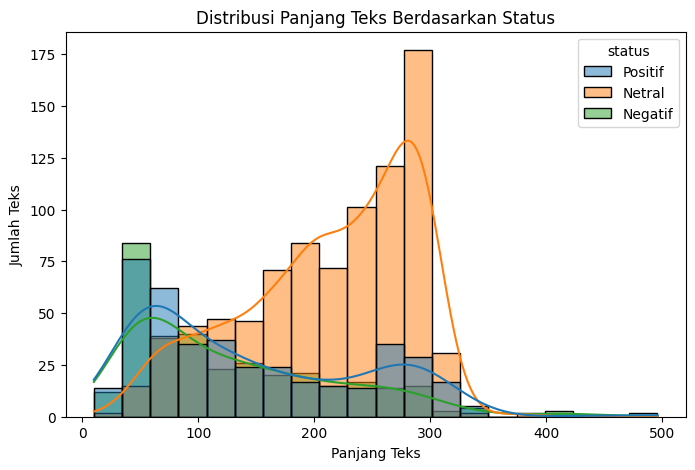

In [ ]:
# Plot distribusi panjang teks
plt.figure(figsize=(8,5))
sns.histplot(df, x="text_length", hue="status", bins=20, kde=True)
plt.title("Distribusi Panjang Teks Berdasarkan Status")
plt.xlabel("Panjang Teks")
plt.ylabel("Jumlah Teks")
plt.show()

In [ ]:
# Ekstrak hashtag dan mention
df["hashtags"] = df["full_text"].apply(lambda x: re.findall(r"#\w+", x))
df["mentions"] = df["full_text"].apply(lambda x: re.findall(r"@\w+", x))

# Gabungkan semua hashtag dan mention
all_hashtags = [tag for tags in df["hashtags"] for tag in tags]
all_mentions = [mention for mentions in df["mentions"] for mention in mentions]

# Hitung frekuensi
hashtags_count = Counter(all_hashtags).most_common(10)
mentions_count = Counter(all_mentions).most_common(10)

# Tampilkan hasil
print(f"\nüîπ Hashtag Terbanyak:\n{hashtags_count}")
print(f"\nüîπ Mention Terbanyak:\n{mentions_count}")



üîπ Hashtag Terbanyak:
[('#SP4NLAPOR', 186), ('#sp4nlapor', 68), ('#SP4NLapor', 60), ('#PelayananPublik', 51), ('#TangerangSemakinGemilang', 36), ('#KominfoDIY', 35), ('#JogjaIstimewa', 33), ('#TangerangOptimis', 31), ('#LaporanPengaduan', 25), ('#LAPOR', 23)]

üîπ Mention Terbanyak:
[('@LAPOR1708', 33), ('@lapor1708', 30), ('@kempanrb', 25), ('@DKIJakarta', 17), ('@merapi_uncover', 13), ('@MorphoMenelausX', 10), ('@vmastratocaster', 10), ('@truzlover', 8), ('@PNS_Ababil', 8), ('@ohzaohh', 7)]


In [ ]:
# Cek jumlah data duplikat berdasarkan 'full_text'
num_duplicates = df["full_text"].duplicated().sum()
num_null = df["full_text"].isnull().sum()
print(f"Jumlah data duplikat: {num_duplicates}")
print(f"Jumlah data null: {num_null}")

Jumlah data duplikat: 0
Jumlah data null: 0


# Preprocessing

In [ ]:
# Kamus normalisasi
kamus_normalisasi = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "ngga": "tidak", "tdk": "tidak", "ndak": "tidak",
    "udah": "sudah", "bikin": "buat", "yg": "yang", "bgt": "banget", "sama2": "sama-sama", "krg": "kurang",
    "jd": "jadi", "udh": "sudah", "blm": "belum", "dr": "dari", "dgn": "dengan", "tp": "tapi", "bkn": "bukan",
    "sm": "sama", "dmn": "dimana", "aja": "saja", "mending": "lebih baik", "krn": "karena", "jgnlah": "janganlah",
    "sy": "saya", "td": "tadi", "trs": "terus", "lg": "lagi", "cm": "cuma", "bbrp": "beberapa"
}

In [ ]:
# 1. Cleaning
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Hapus RT
    text = re.sub(r'https?://\S+', '', text)  # Hapus URL
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Hapus angka & karakter spesial
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi ganda
    return text

df["clean_text"] = df["full_text"].apply(clean_text)

In [ ]:
# 2. Case Folding
df['folding_text'] = df['clean_text'].str.lower()

In [ ]:
# 3. Normalization
def normalize_text(text):
    words = text.split()
    normalized_words = [kamus_normalisasi[word] if word in kamus_normalisasi else word for word in words]
    return ' '.join(normalized_words)

df["normalized_text"] = df["folding_text"].apply(normalize_text)

In [ ]:
# 4. Tokenizing
df['tokenized'] = df['normalized_text'].apply(word_tokenize)

In [ ]:
# 5. Stopword Removal
stop_words = set(stopwords.words('indonesian'))
df['filtered'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

In [ ]:
# 6. Filtering Kata Pendek dan Kata Jarang
df['filtered'] = df['filtered'].apply(lambda x: [word for word in x if len(word) > 2])
word_counts = Counter([word for sublist in df['filtered'] for word in sublist])
min_freq = 5  # Kata harus muncul lebih dari 5 kali untuk dipertahankan
df['filtered'] = df['filtered'].apply(lambda x: [word for word in x if word_counts[word] > min_freq])

In [ ]:
# 7. Stemming
stemmer = StemmerFactory().create_stemmer()
df['stemmed'] = df['filtered'].apply(lambda x: [stemmer.stem(word) for word in x])

In [ ]:
# 8. Gabungkan kembali hasil stemming
df['processed_text'] = df['stemmed'].apply(lambda x: ' '.join(x))
df.head(5)

full_text   status  text_length  \
0  Jika sobat BKD menemukan keluhan seputar layan...  Positif          286   
1  Pemko Palangka Raya melalui Diskominfo menyele...   Netral          228   
2  Salah satu upaya keterbukaan informasi dlm pel...  Positif          302   
3  Halo sobat parekraf Saat kamu bingung mau mela...  Positif          209   
4  Hai TemanKom! Berikut Data Jumlah Pengaduan Ma...   Netral          169   

                                           hashtags  \
0  [#ASNBerakhlak, #BKDProvJateng, #SobatASNJateng]   
1                                                []   
2                                                []   
3           [#WonderfulIndonesia, #PesonaIndonesia]   
4                                                []   

                     mentions  \
0  [@kipjateng, @ppid_jateng]   
1                          []   
2                          []   
3                          []   
4                          []   

                                          clean_text  \
0  Jika sobat BKD menemukan keluhan seputar layan...   
1  Pemko Palangka Raya melalui Diskominfo menyele...   
2  Salah satu upaya keterbukaan informasi dlm pel...   
3  Halo sobat parekraf Saat kamu bingung mau mela...   
4  Hai TemanKom Berikut Data Jumlah Pengaduan Mas...   

                                        folding_text  \
0  jika sobat bkd menemukan keluhan seputar layan...   
1  pemko palangka raya melalui diskominfo menyele...   
2  salah satu upaya keterbukaan informasi dlm pel...   
3  halo sobat parekraf saat kamu bingung mau mela...   
4  hai temankom berikut data jumlah pengaduan mas...   

                                     normalized_text  \
0  jika sobat bkd menemukan keluhan seputar layan...   
1  pemko palangka raya melalui diskominfo menyele...   
2  salah satu upaya keterbukaan informasi dlm pel...   
3  halo sobat parekraf saat kamu bingung mau mela...   
4  hai temankom berikut data jumlah pengaduan mas...   

                                           tokenized  \
0  [jika, sobat, bkd, menemukan, keluhan, seputar...   
1  [pemko, palangka, raya, melalui, diskominfo, m...   
2  [salah, satu, upaya, keterbukaan, informasi, d...   
3  [halo, sobat, parekraf, saat, kamu, bingung, m...   
4  [hai, temankom, berikut, data, jumlah, pengadu...   

                                            filtered  \
0  [sobat, menemukan, keluhan, layanan, publik, p...   
1  [pemko, palangka, raya, diskominfo, menyelengg...   
2  [salah, upaya, informasi, dlm, pelayanan, publ...   
3  [halo, sobat, bingung, pelaporan, kemana, spnl...   
4  [hai, temankom, data, pengaduan, masyarakat, k...   

                                             stemmed  \
0  [sobat, temu, keluh, layan, publik, platform, ...   
1  [pemko, palangka, raya, diskominfo, selenggara...   
2  [salah, upaya, informasi, dlm, layan, publik, ...   
3  [halo, sobat, bingung, lapor, mana, spnlapor, ...   
4  [hai, temankom, data, adu, masyarakat, kota, b...   

                                      processed_text  
0  sobat temu keluh layan publik platform laporgu...  
1  pemko palangka raya diskominfo selenggara sosi...  
2  salah upaya informasi dlm layan publik adu lay...  
3         halo sobat bingung lapor mana spnlapor yuk  
4  hai temankom data adu masyarakat kota bogor ma...

In [ ]:
# Gabungkan teks berdasarkan status
positif_text_raw = " ".join(df[df["status"] == "Positif"]["processed_text"])
netral_text_raw = " ".join(df[df["status"] == "Netral"]["processed_text"])
negatif_text_raw = " ".join(df[df["status"] == "Negatif"]["processed_text"])

# Fungsi untuk hitung 5 kata paling sering
def most_common_words(text, label, n=5):
    tokens = text.split()
    counter = Counter(tokens)
    most_common = counter.most_common(n)
    print(f"\nTop {n} kata paling sering pada kategori '{label}':")
    for word, freq in most_common:
        print(f"{word}: {freq}")

# Tampilkan kata paling sering
most_common_words(positif_text_raw, "Positif")
most_common_words(netral_text_raw, "Netral")
most_common_words(negatif_text_raw, "Negatif")


Top 5 kata paling sering pada kategori 'Positif':
lapor: 310
layan: 134
spn: 129
aplikasi: 124
adu: 120

Top 5 kata paling sering pada kategori 'Netral':
lapor: 611
adu: 473
spn: 360
spnlapor: 347
layan: 290

Top 5 kata paling sering pada kategori 'Negatif':
lapor: 278
aplikasi: 159
spn: 45
perintah: 31
masyarakat: 31


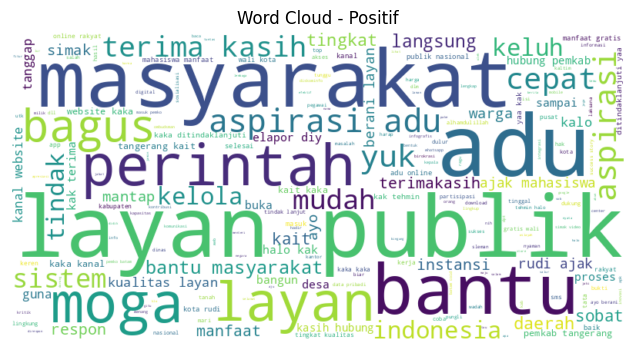

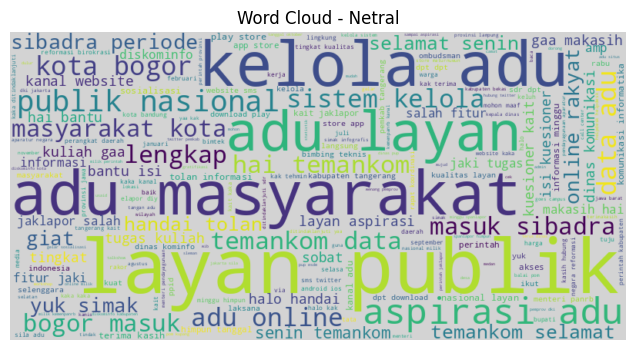

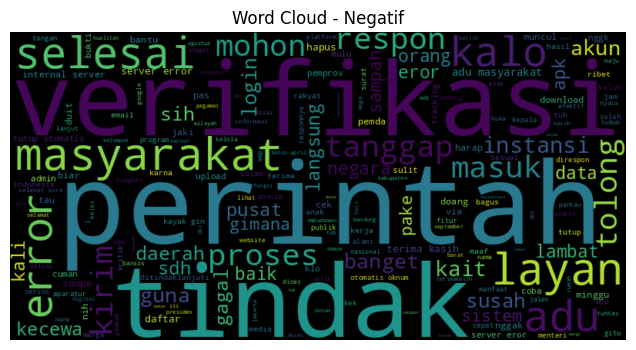

In [ ]:
# Daftar kata yang ingin dihapus
stop_words = {"lapor", "sp4n", "sp4nlapor","spnlapor","spn","aplikasi","nya"}

# Fungsi untuk hapus kata tertentu
def remove_specific_words(text, words_to_remove):
    return " ".join([word for word in text.split() if word not in words_to_remove])

# Hapus kata yang ditentukan
positif_text_cleaned = remove_specific_words(positif_text_raw, stop_words)
netral_text_cleaned = remove_specific_words(netral_text_raw, stop_words)
negatif_text_cleaned = remove_specific_words(negatif_text_raw, stop_words)

# Fungsi untuk membuat Word Cloud
def generate_wordcloud(text, title, color="white"):
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color=color).generate(text)
        plt.figure(figsize=(8,4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print(f"\n Tidak ada kata untuk {title}")

# Word Cloud setelah hapus kata tertentu
generate_wordcloud(positif_text_cleaned, "Word Cloud - Positif", color='white')
generate_wordcloud(netral_text_cleaned, "Word Cloud - Netral", color='lightgray')
generate_wordcloud(negatif_text_cleaned, "Word Cloud - Negatif", color='black')

In [ ]:
# Pastikan label tetap menggunakan -1, 0, 1 (Negatif, Netral, Positif)
label_mapping = {'Negatif': -1, 'Netral': 0, 'Positif': 1}
df['status'] = df['status'].map(label_mapping)

# Model

In [ ]:
# Define features and target
X = df['processed_text']
y = df['status']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter Tuning

## Hyperparameter Tuning Model


SVM best parameters: {'C': 10}
SVM (TF-IDF + Bigram + Tuning) Classification Report:

              precision    recall  f1-score   support

          -1       0.79      0.81      0.80       171
           0       0.75      0.79      0.77       171
           1       0.77      0.71      0.74       171

    accuracy                           0.77       513
   macro avg       0.77      0.77      0.77       513
weighted avg       0.77      0.77      0.77       513


Logistic Regression best parameters: {'C': 10}
Logistic Regression (TF-IDF + Bigram + Tuning) Classification Report:

              precision    recall  f1-score   support

          -1       0.82      0.84      0.83       171
           0       0.74      0.81      0.77       171
           1       0.81      0.71      0.76       171

    accuracy                           0.79       513
   macro avg       0.79      0.79      0.79       513
weighted avg       0.79      0.79      0.79       513


Random Forest best parameters: 

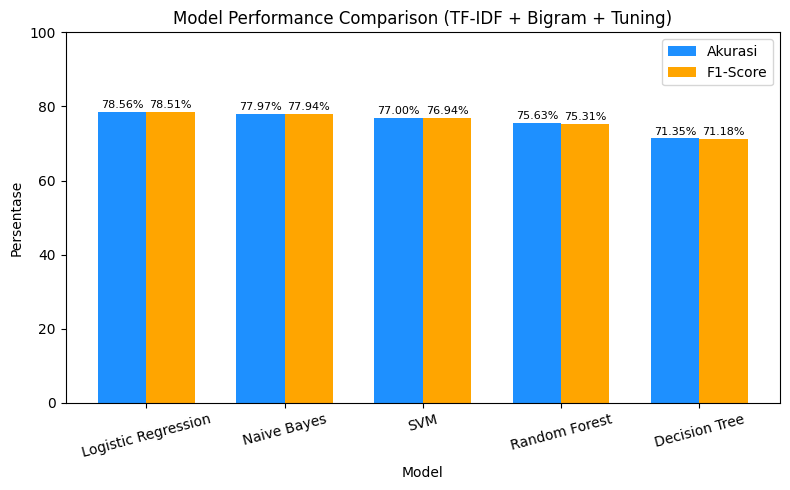


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
1  Logistic Regression  0.785575   0.787686  0.785575  0.785101
3          Naive Bayes  0.779727   0.779357  0.779727  0.779417
0                  SVM  0.769981   0.770158  0.769981  0.769396
2        Random Forest  0.756335   0.758659  0.756335  0.753130
4        Decision Tree  0.713450   0.712021  0.713450  0.711830


In [ ]:
from sklearn.model_selection import GridSearchCV

# TF-IDF dengan Unigram + Bigram
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
X_test_smote, y_test_smote = smote.fit_resample(X_test_tfidf, y_test)

# Hyperparameter Tuning untuk semua model
tuned_models = {}

# SVM Tuning
svm_params = {'C': [0.1, 1, 10]}
svm = GridSearchCV(SVC(kernel='linear', probability=True, class_weight='balanced'), svm_params, cv=3)
svm.fit(X_train_smote, y_train_smote)
tuned_models['SVM'] = svm

# Logistic Regression Tuning
logreg_params = {'C': [0.1, 1, 10]}
logreg = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), logreg_params, cv=3)
logreg.fit(X_train_smote, y_train_smote)
tuned_models['Logistic Regression'] = logreg

# Random Forest Tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), rf_params, cv=3)
rf.fit(X_train_smote, y_train_smote)
tuned_models['Random Forest'] = rf

# Naive Bayes Tuning
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb = GridSearchCV(MultinomialNB(), nb_params, cv=3)
nb.fit(X_train_smote, y_train_smote)
tuned_models['Naive Bayes'] = nb

# Decision Tree Tuning
dt_params = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'), dt_params, cv=3)
dt.fit(X_train_smote, y_train_smote)
tuned_models['Decision Tree'] = dt

# Evaluasi
results_with_smote = []

for name, model_search in tuned_models.items():
    model = model_search.best_estimator_
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_smote)

    accuracy = accuracy_score(y_test_smote, y_pred)
    precision = precision_score(y_test_smote, y_pred, average='macro')
    recall = recall_score(y_test_smote, y_pred, average='macro')
    f1 = f1_score(y_test_smote, y_pred, average='macro')

    results_with_smote.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    print(f"\n{name} best parameters: {model_search.best_params_}")
    print(f"{name} (TF-IDF + Bigram + Tuning) Classification Report:\n")
    print(classification_report(y_test_smote, y_pred))


# DataFrame hasil
results_df = pd.DataFrame(results_with_smote).sort_values(by='Accuracy', ascending=False)

# Visualisasi
index = np.arange(len(results_df))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(index, results_df['Accuracy'] * 100, bar_width, label='Akurasi', color='dodgerblue')
bars2 = ax.bar(index + bar_width, results_df['F1-Score'] * 100, bar_width, label='F1-Score', color='orange')

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', fontsize=8)

ax.set_xlabel('Model')
ax.set_ylabel('Persentase')
ax.set_title('Model Performance Comparison (TF-IDF + Bigram + Tuning)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(results_df['Model'], rotation=15)
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()

# Tampilkan tabel hasil akhir
print("\nModel Comparison:")
print(results_df)




Confusion Matrix untuk SVM


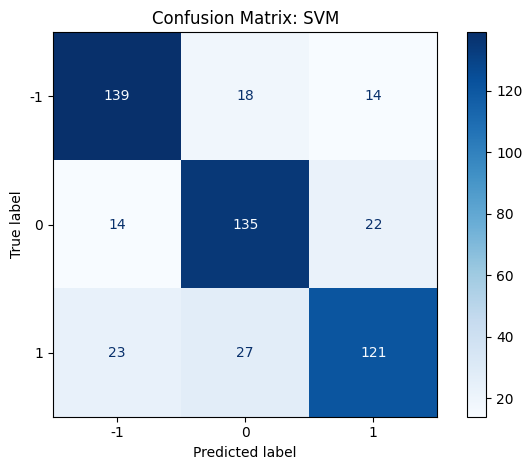


Confusion Matrix untuk Logistic Regression


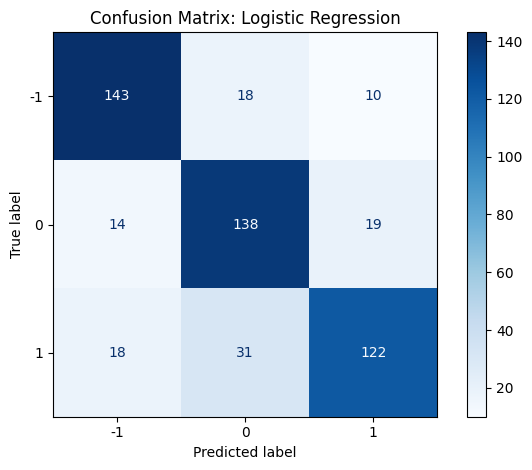


Confusion Matrix untuk Random Forest


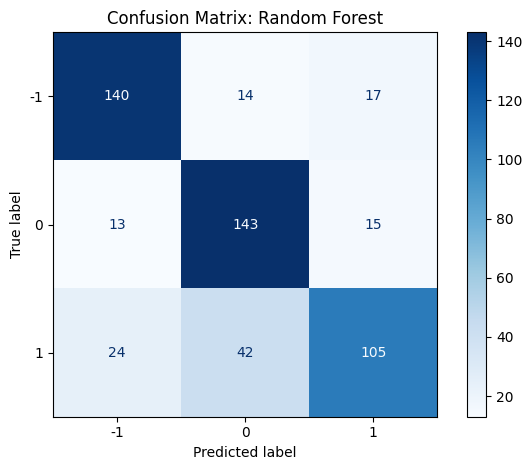


Confusion Matrix untuk Naive Bayes


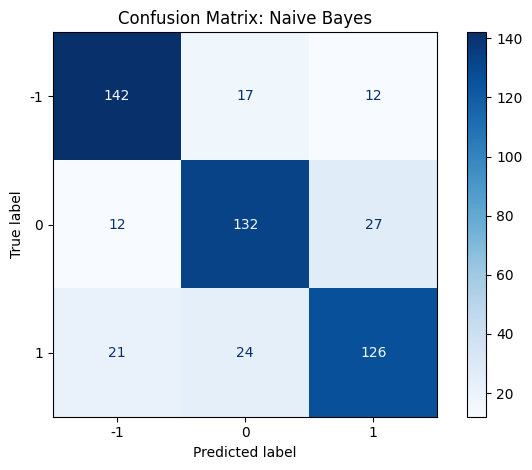


Confusion Matrix untuk Decision Tree


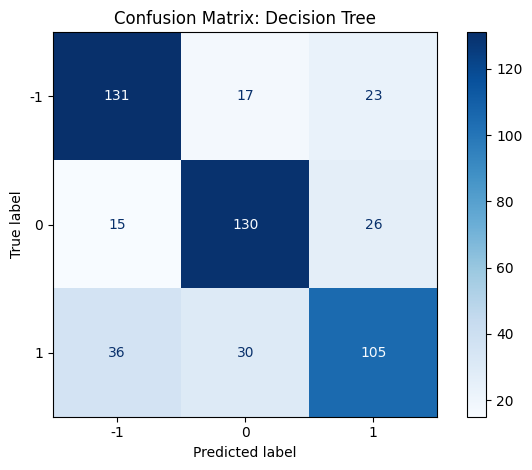

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Dictionary untuk menyimpan label dan prediksi dari tiap model
conf_matrix_data = {}

# SMOTE pada data uji
X_test_smote, y_test_smote = SMOTE(random_state=42).fit_resample(X_test_tfidf, y_test)

# Loop untuk semua model yang sudah dituning
for name, model_search in tuned_models.items():
    model = model_search.best_estimator_
   # model.fit(X_train_smote, y_train_smote)  # latih di data SMOTE training
    y_pred = model.predict(X_test_smote)

    # Simpan nilai true dan prediksi
    conf_matrix_data[name] = (y_test_smote, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test_smote, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    # Visualisasi
    print(f"\nConfusion Matrix untuk {name}")
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Dictionary untuk menyimpan label dan prediksi dari tiap model
conf_matrix_data = {}

# SMOTE pada data uji
X_test_smote, y_test_smote = SMOTE(random_state=42).fit_resample(X_test_tfidf, y_test)

# Loop untuk semua model yang sudah dituning
for name, model_search in tuned_models.items():
    model = model_search.best_estimator_
    # model.fit(X_train_smote, y_train_smote)   # latih di data SMOTE training
    y_pred = model.predict(X_test_smote)

    # Simpan nilai true dan prediksi
    conf_matrix_data[name] = (y_test_smote, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test_smote, y_pred, labels=model.classes_)

    # Output teks confusion matrix
    print(f"\nConfusion Matrix untuk {name}:")
    print("Predicted")
    print(" " * 8 + " ".join(map(str, model.classes_)))
    print("Actual")
    for i, row in enumerate(cm):
        print(f" {model.classes_[i]:<4}  {' '.join(map(str, row))}")


Confusion Matrix untuk SVM:
Predicted
        -1 0 1
Actual
 -1    139 18 14
 0     14 135 22
 1     23 27 121

Confusion Matrix untuk Logistic Regression:
Predicted
        -1 0 1
Actual
 -1    143 18 10
 0     14 138 19
 1     18 31 122

Confusion Matrix untuk Random Forest:
Predicted
        -1 0 1
Actual
 -1    140 14 17
 0     13 143 15
 1     24 42 105

Confusion Matrix untuk Naive Bayes:
Predicted
        -1 0 1
Actual
 -1    142 17 12
 0     12 132 27
 1     21 24 126

Confusion Matrix untuk Decision Tree:
Predicted
        -1 0 1
Actual
 -1    131 17 23
 0     15 130 26
 1     36 30 105


Distribusi Sebelum SMOTE: Counter({0: 683, 1: 325, -1: 270})
Distribusi Setelah SMOTE: Counter({0: 683, -1: 683, 1: 683})


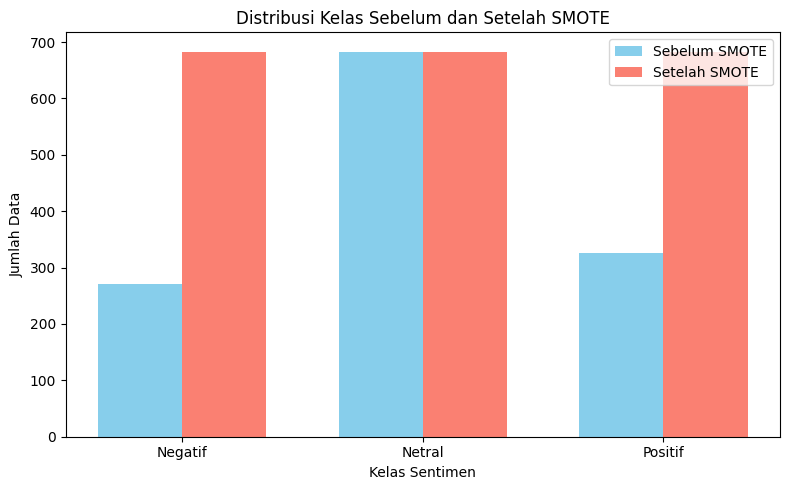

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# Sebelum SMOTE
original_dist = Counter(y_train)
print("Distribusi Sebelum SMOTE:", original_dist)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Setelah SMOTE
smote_dist = Counter(y_train_smote)
print("Distribusi Setelah SMOTE:", smote_dist)

# Visualisasi
labels = ['Negatif', 'Netral', 'Positif']
original_counts = [original_dist.get(label, 0) for label in sorted(original_dist)]
smote_counts = [smote_dist.get(label, 0) for label in sorted(smote_dist)]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, original_counts, width=width, label='Sebelum SMOTE', color='skyblue')
plt.bar([i + width for i in x], smote_counts, width=width, label='Setelah SMOTE', color='salmon')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Kelas Sebelum dan Setelah SMOTE')
plt.xticks([i + width / 2 for i in x], labels)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd

# Misal: y adalah label target (berisi -1, 0, 1)
# Gantilah variabel `X` dan `y` dengan punyamu

# Split data (contoh 80% train dan 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Tampilkan distribusi kelas
print("Distribusi Seluruh Data:", Counter(y))
print("Distribusi Data Training:", Counter(y_train))
print("Distribusi Data Testing:", Counter(y_test))


Distribusi Seluruh Data: Counter({0: 854, 1: 407, -1: 337})
Distribusi Data Training: Counter({0: 683, 1: 325, -1: 270})
Distribusi Data Testing: Counter({0: 171, 1: 82, -1: 67})
